<a href="https://colab.research.google.com/github/NolanJMcCafferty/neural-style-transfer/blob/master/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### This notebook provides an implementation of neural style transfer using TensorFlow 2.0.

In [0]:
# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

First, we import the example images for our analysis from Wikipedia commons. 

In [0]:
import os
img_dir = '/nst'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)
!wget --quiet -P /nst/ https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
!wget --quiet -P /nst/ https://upload.wikimedia.org/wikipedia/commons/5/5c/Beagle_Dogs.jpg
!wget --quiet -P /nst/ https://upload.wikimedia.org/wikipedia/commons/5/5c/Pomona_College_Walker_Beach.jpg
!wget --quiet -P /nst/ https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
!wget --quiet -P /nst/ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget --quiet -P /nst/ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
!wget --quiet -P /nst/ https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
!wget --quiet -P /nst/ https://en.wikipedia.org/wiki/File:Pablo_Picasso,_1909-10,_Figure_dans_un_Fauteuil_(Seated_Nude,_Femme_nue_assise),_oil_on_canvas,_92.1_x_73_cm,_Tate_Modern,_London.jpg

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `wget --quiet -P /nst/ https://en.wikipedia.org/wiki/File:Pablo_Picasso,_1909-10,_Figure_dans_un_Fauteuil_(Seated_Nude,_Femme_nue_assise),_oil_on_canvas,_92.1_x_73_cm,_Tate_Modern,_London.jpg'


In [0]:
!ls /nst/

1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg.1
1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg.2
Beagle_Dogs.jpg
Beagle_Dogs.jpg.1
Beagle_Dogs.jpg.2
Green_Sea_Turtle_grazing_seagrass.jpg
Green_Sea_Turtle_grazing_seagrass.jpg.1
Green_Sea_Turtle_grazing_seagrass.jpg.2
Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg.1
Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg.2
Pomona_College_Walker_Beach.jpg
Pomona_College_Walker_Beach.jpg.1
The_Great_Wave_off_Kanagawa.jpg
The_Great_Wave_off_Kanagawa.jpg.1
The_Great_Wave_off_Kanagawa.jpg.2
Vassily_Kandinsky,_1913_-_Composition_7.jpg
Vassily_Kandinsky,_1913_-_Composition_7.jpg.1
Vassily_Kandinsky,_1913_-_Composition_7.jpg.2


Next, we have auxiliary functions for preprocessing and deproccesing the images for use in our algorithm. 

In [0]:
import numpy as np
from keras.applications import vgg19
from keras.preprocessing.image import load_img, img_to_array

norm_means = np.array([103.939, 116.779, 123.68])

def preprocess_image(img_path):
    img = load_img(img_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    x = img.copy()

    if len(x.shape) == 4:
      x = np.squeeze(x, 0)

    # Remove zero-center by mean pixel
    x[:, :,] += norm_means
    
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Below are two more auxilliary functions for displaying the results of our style transfer. 

In [0]:
def imshow(img, title=None):
  if title is not None:
    title = plt.title(title)
    plt.setp(title, color='w')
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])

def show_results(content_path, style_path, best_img=None):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if best_img is not None: 
    plt.figure(figsize=(10, 10))
    imshow(best_img, 'Output Image')

In [0]:
import matplotlib.pyplot as plt

content_path = '/nst/Beagle_Dogs.jpg'
style_path = '/nst/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'

# scale images
width, height = load_img(content_path).size
img_height = 400
img_width = int(width * img_height / height)

show_results(content_path, style_path)

In order to preserve the content of our example content image in our output, we use the feature maps from the last convolutional layer in our trained CNN, because as you move through the CNN the maps represent higher and higher level features. 

For style preservation, we need to use both low and high level features. Thus, we will use the feature maps from several convolutional layers throughout the CNN.

The following shows a summary of the pre-trained VGG19 architecture:

In [0]:
model = tf.keras.applications.vgg19.VGG19(include_top=False)
print(model.summary())

80142336/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

Looking at the model architecture above, it seems reasonable that the content should be represented by layer `block5_conv4` and the style by several equally spaced convolutional layers. 

In [0]:
content_layers = ['block5_conv4'] 

style_layers = [
  'block1_conv1',
  'block2_conv1',
  'block3_conv1', 
  'block4_conv1', 
	'block5_conv1'
]
num_style_layers = len(style_layers)

Now, we create our application specific model using the pre-trained VGG19 network with the output as our desired content and style layers. 

In [0]:
from tensorflow.keras import Model
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  
  return Model(vgg.input, model_outputs)

#### Now, we define our content and style loss functions: 

For content we simply want the final layer difference between our reference image and the output. 

However, the style loss is slightly more complex. Not only do we want to capture the common low level features present in the syle reference image, e.g. color or brush strokes, we also want to mimic the proper *correlations* of these low level features. For this notion of correlation, we use the difference betweem Gram matrices at each style layer for the two images. 

In [0]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))
  
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)
 
def get_style_loss(base_style, gram_target):
  # height, width, num filters of each layer
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

Next, a function to extract the style and content features from the model output.

In [0]:
def get_feature_representations(model, content_path, style_path):
  content_image = preprocess_image(content_path)
  style_image = preprocess_image(style_path)
  
  # compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features

The `compute_loss` function below runs the a given image through our model and computes the loss associated with that image, incorporating user-defined weights for content and style respectively.

The `compute_grads` function uses our loss function to compute and save the gradient with respect to a combination image, which can then be used by the optimizer in the main `run_style_transfer` loop below.

In [0]:
def compute_loss(model, weights, init_image, gram_style_features, content_features): 

  style_weight, content_weight, total_var_weight = weights
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers.
  model_outputs = model(init_image)
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0
  total_var_score = total_var_weight * tf.image.total_variation(init_image).numpy()[0]

  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
  style_score *= style_weight

  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += get_content_loss(comb_content[0], target_content)
  content_score *= content_weight
  
  # Get total loss
  loss = style_score + content_score + total_var_score
  return loss, style_score, content_score, total_var_score

def compute_grads(config):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**config)

  total_loss = all_loss[0]
  return tape.gradient(total_loss, config['init_image']), all_loss

#### Finally, we have the main running loop for our neural style transfer algorithm. 

The user can define a number of epochs for the algorithm to run, as well as specific weights for the content and style weights for use in the loss function. If content retention is the priority for the output image, the user could increase the content weight or decrease the style weight and vice versa for a focus on style retention. 

During the optimization, the function displays intermediate images and loss values at defined intervals. After the algorithm completes, the entire transformation of the output image is displayed. 

In [0]:
import time
import IPython.display
from PIL import Image

def run_style_transfer(
    content_path, 
    style_path,
    epochs=600,
    style_weight=1e-4,
    content_weight=100,
    total_var_weight=1e-3,
    display_final=True
): 
  # set up the notebook display
  if display_final: plt.figure(figsize=(15, 7))
  num_rows = 2
  num_cols = 3
  global_start = time.time()
  start_time = time.time()

  min_vals = -norm_means
  max_vals = 255 - norm_means  
  
  # Get the reference style and content feature representations
  model = get_model() 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = preprocess_image(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)

  # Create our optimizer
  opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  config = {
      'model': model,
      'weights': (style_weight, content_weight, total_var_weight),
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
  
  for i in range(epochs):
    grads, all_loss = compute_grads(config)
    loss, style_score, content_score, total_var_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    # clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    # init_image.assign(clipped)
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_image(init_image.numpy())

    # display intermediate image
    if i % (epochs / (num_rows * num_cols)) == 0:
      IPython.display.clear_output(wait=True)
      iter_time = time.time() - start_time
      print(
          f'Iteration: {i}\n'        
          f'Loss: {loss:.3e}, '
          f'style score: {style_score:.3e}, '
          f'content score: {content_score:.3e}, '
          f'total variation score: {total_var_score:.3e}, '
          f'time: {iter_time:.3f}s\n'
      )
          
      plot_img = init_image.numpy()
      plot_img = deprocess_image(plot_img)
      IPython.display.display_png(Image.fromarray(plot_img))

      # image for final output
      if display_final:
        display_count = i * num_rows * num_cols / epochs + 1
        plt.subplot(num_rows, num_cols, display_count)
        imshow(plot_img, f'Iteration {i}')

      start_time = time.time()  

  IPython.display.clear_output(wait=True) 
  if display_final:
    total_time = time.time() - global_start
    print(f'Total time: {total_time:.3f}s, Best loss: {best_loss:.3e}')

  return best_img, best_loss

Total time: 128.284s, Best loss: 4.295e+04


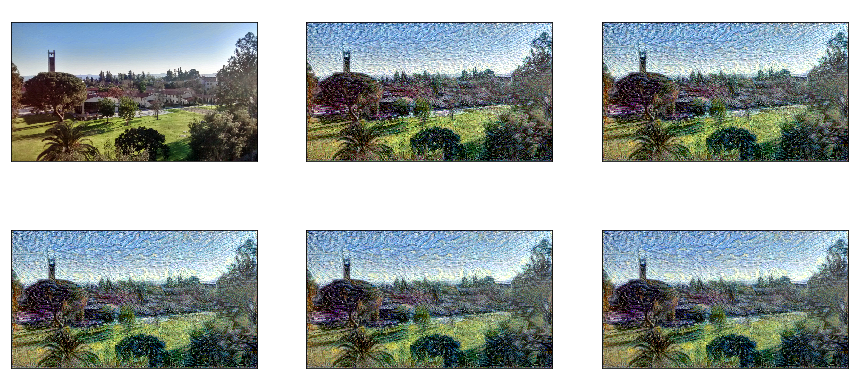

In [0]:
best, best_loss = run_style_transfer(
    content_path, 
    style_path,
)

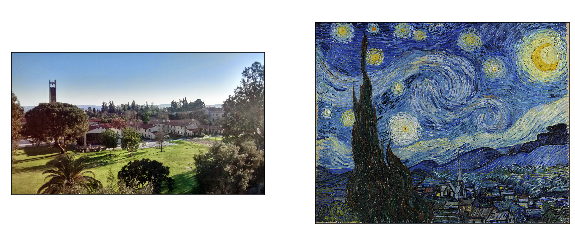

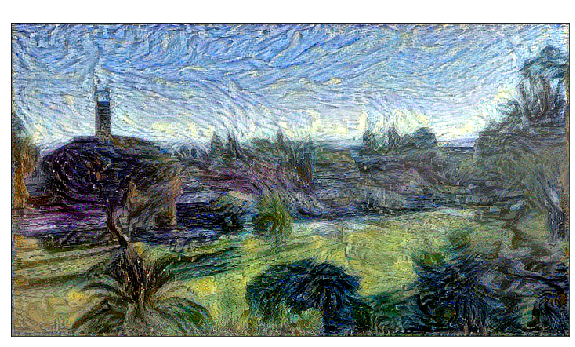

In [0]:
show_results(
    content_path, 
    style_path,
    best)

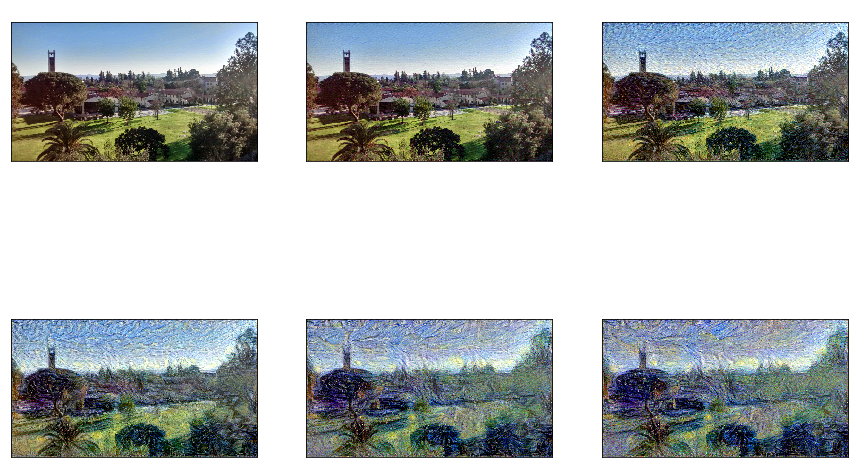

In [0]:
plt.figure(figsize=(15, 10))
style_weight = 1e-8

for i in range(6):
  style_weight *= 10
  best_img, best_loss = run_style_transfer(
    content_path, 
    style_path,
    display_final=False,
    style_weight=style_weight
  ) 
  
  plt.subplot(2, 3, i + 1)
  imshow(
      best_img, 
      f'Style Weight: {style_weight:.2e}'
  )
plt.show()

In [0]:
!ls /nst

1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg.1
1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg.2
Beagle_Dogs.jpg
Beagle_Dogs.jpg.1
Beagle_Dogs.jpg.2
Green_Sea_Turtle_grazing_seagrass.jpg
Green_Sea_Turtle_grazing_seagrass.jpg.1
Green_Sea_Turtle_grazing_seagrass.jpg.2
Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg.1
Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg.2
Pomona_College_Walker_Beach.jpg
Pomona_College_Walker_Beach.jpg.1
The_Great_Wave_off_Kanagawa.jpg
The_Great_Wave_off_Kanagawa.jpg.1
The_Great_Wave_off_Kanagawa.jpg.2
Vassily_Kandinsky,_1913_-_Composition_7.jpg
Vassily_Kandinsky,_1913_-_Composition_7.jpg.1
Vassily_Kandinsky,_1913_-_Composition_7.jpg.2
